In [76]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils


# Use MPS to speed up training

# dev = torch.device(
    # "mps") if torch.backends.mps.is_available() else torch.device("cpu")
dev = torch.device("cpu")

# Load training and validation data
train = pd.read_csv('train.csv')
# Drop id 
train.drop(['id'], axis=1, inplace=True)

# Split into x and y, converting to float tensors
target_col = 'MedHouseVal'
x_train = torch.tensor(train.drop([target_col], axis=1).values).float()
y_train = torch.tensor(train[target_col].values).float()


def torch_standardize(x):
    mean = torch.mean(x, dim=0)
    std = torch.std(x, dim=0)
    return ((x - mean) / std, mean, std)

# Preprocess the data in a function
def preprocess(x):
    """Function for preprocessing the data before training. Currently normalizing,
    standardizing, and keeping the original values for the neural network. We 
    will pass all three concatenated to our model, and let it decide which ones
    to use.
    We will L2, L1 normalize and min/max normalize the features of x.
    For now we will focus on standardizing the data, and later we will add more
    """
    # x_norm_2 = F.normalize(x, p=2, dim=0)
    # x_norm_1 = F.normalize(x, p=1, dim=0)
    x_std, mean, std = torch_standardize(x)
    # x_minmax = (x - torch.min(x, dim=0)[0]) / (torch.max(x, dim=0)[0] - torch.min(x, dim=0)[0])
    # Save parameters of standardization for later
    return torch.cat((x,x_std), dim=1), mean, std

def prepocess_test(x, mean, std):
    """Function for preprocessing the test data. We will use the mean and std
    of the training data to standardize the test data."""
    x_std = (x - mean) / std
    return torch.cat((x,x_std), dim=1)
    
x_train,mean,std = preprocess(x_train)

batch_size = 256
train_dataset = TensorDataset(x_train, y_train)
full_train_dataset = TensorDataset(x_train, y_train)
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)

# Split into train and val
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [86]:
# Define model
class HousePricesModel(nn.Module):
    def __init__(self):
        super(HousePricesModel, self).__init__()
        self.fc1 = nn.Linear(16, 12)
        self.fc2 = nn.Linear(12, 8)
        self.fc3 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(4, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
def create_model_optimizer_loss(lr = 0.001):
    model = HousePricesModel().to(dev)
    # optimizer = optim.Adam(model.parameters(), lr=lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    # Adagra
    optimizer = optim.Adagrad(model.parameters(), lr=lr)
    loss_func = nn.MSELoss(reduction='mean')
    return model, optimizer, loss_func


model, optimizer, loss_func = create_model_optimizer_loss()

def train(model,opt,epochs=10, train_dl=train_loader, val_dl=val_loader, loss_func=loss_func, dev=dev):
    loss_vals = []
    print("-"*30)
    print(f"Training model: {model.__class__.__name__}")
    print(f"Optimizer: {opt.__class__.__name__}")
    print()
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(dev), yb.to(dev)
            y_hat = model(xb)
            y_hat = y_hat.squeeze()
            loss = loss_func(y_hat, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        model.eval()
        with torch.no_grad():
            tot_loss = 0
            for xb, yb in val_dl:
                xb, yb = xb.to(dev), yb.to(dev)
                y_hat = model(xb)
                y_hat = y_hat.squeeze()
                loss = loss_func(y_hat, yb)
                tot_loss += loss.item() 
            val_loss = tot_loss / len(val_dl)
            print(f"Epoch: {epoch}")
            print(f"Validation loss: {val_loss}")
            print()
            loss_vals.append(val_loss)

    return loss_vals

def hyperparam_search(lr_vals, epochs=200):
    """Function for searching for optimal hyperparameters. We will search for
    the optimal learning rate."""

    results = {}
    for lr in lr_vals:
        model, optimizer, loss_func = create_model_optimizer_loss(lr)
        loss_vals = train(model,optimizer,epochs=epochs)
        print(f"Learning rate: {lr}")
        print(f"Validation loss: {loss_vals[-1]}")
        print()
        results[lr] = loss_vals
    
    return results

results = hyperparam_search([0.5,0.3,0.1,0.01,0.001,0.0001],epochs = 200)

------------------------------
Training model: HousePricesModel
Optimizer: Adagrad

Epoch: 0
Validation loss: 1.3782976706822714

Epoch: 1
Validation loss: 1.3791166504224142

Epoch: 2
Validation loss: 1.3783202012379965

Epoch: 3
Validation loss: 1.3783244450887044

Epoch: 4
Validation loss: 1.378425931930542

Epoch: 5
Validation loss: 1.3783274213473002

Epoch: 6
Validation loss: 1.3783169031143188

Epoch: 7
Validation loss: 1.3804552912712098

Epoch: 8
Validation loss: 1.3783402721087137

Epoch: 9
Validation loss: 1.3783256928126018

Epoch: 10
Validation loss: 1.3785725990931192

Epoch: 11
Validation loss: 1.3782999714215596

Epoch: 12
Validation loss: 1.3786994735399882

Epoch: 13
Validation loss: 1.3792162497838338

Epoch: 14
Validation loss: 1.380657951037089

Epoch: 15
Validation loss: 1.3787372628847758

Epoch: 16
Validation loss: 1.3804918766021728

Epoch: 17
Validation loss: 1.37976363102595

Epoch: 18
Validation loss: 1.3790251811345418

Epoch: 19
Validation loss: 1.37906358

In [89]:
# Print last validation loss for each learning rate
for lr in results:
    print(f"Learning rate: {lr}")
    print(f"Validation loss: {results[lr][-1]}")
    print()

Learning rate: 0.5
Validation loss: 1.378341277440389

Learning rate: 0.3
Validation loss: 1.3928580045700074

Learning rate: 0.1
Validation loss: 0.5300090618431568

Learning rate: 0.01
Validation loss: 0.4851390908161799

Learning rate: 0.001
Validation loss: 0.8609747648239136

Learning rate: 0.0001
Validation loss: 17.47362642288208



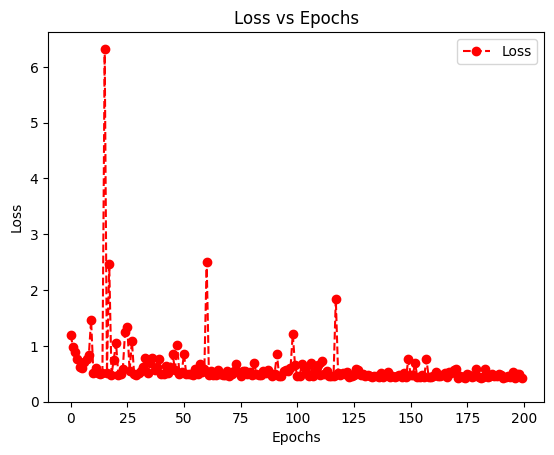

<Figure size 640x480 with 0 Axes>

In [59]:
import matplotlib.pyplot as plt
def plot_loss(loss_vals):
    plt.plot(loss_vals, label="Loss", color="red", linestyle="dashed", marker="o")
    plt.legend()
    # Add title to x axis
    plt.xlabel("Epochs")
    # Add title to y axis
    plt.ylabel("Loss")
    # Add title to graph
    plt.title("Loss vs Epochs")
    # Only show integer epochs 
    # Set y-axis to start at 0
    plt.ylim(0)

    # Plot accuracy in a seperate plot 
    plt.figure()
    # Plot


plot_loss(loss_vals[:]);

In [ ]:
# Train model on all of the training data 
model, optimizer, loss_func = create_model_optimizer_loss(lr=0.001)
loss_vals = train(model,optimizer,epochs=200, train_dl=full_train_loader)



In [50]:
# Load test data and create kaggle submission
test = pd.read_csv('test.csv')

# Drop id
test.drop(['id'], axis=1, inplace=True)

# Convert to tensor
x_test = torch.tensor(test.values).float()

# Preprocess test data
x_test = prepocess_test(x_test, mean, std)

# Create test dataset
test_dataset = TensorDataset(x_test)

# Run model on test data
model.eval()
model(x_test)

# Create submission
submission = pd.read_csv('sample_submission.csv')
submission[target_col] = model(x_test).detach().numpy()
submission.to_csv('submission.csv', index=False)


In [51]:
%%bash
/Users/dbless/Library/Python/3.11/bin/kaggle competitions submit -c playground-series-s3e1 -f submission.csv -m "Message"

100%|██████████| 383k/383k [00:03<00:00, 118kB/s]  


Successfully submitted to Playground Series - Season 3, Episode 1